# SVM Closed & Open world experiment

## 1. Data Download and Feature Extraction Tools

In [ ]:
# Import
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import gdown
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, balanced_accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier


# ============================================
# 0) Data Auto Download Setup
# ============================================

FILE_IDS = {
    "mon_standard.pkl": "1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63",
    "unmon_standard10.pkl": "1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn",
}

# Check gdown installation
try:
    gdown.download_folder
except AttributeError:
    !pip install gdown

# Automatically downloads data using Google Drive File IDs to the local environment.
def download_data_for_colab():
    for filename, file_id in FILE_IDS.items():
        filepath = f'/content/{filename}'
        if not os.path.exists(filepath):
            # Execute gdown
            !gdown --id $file_id -O $filepath --fuzzy

# Set seed for reproducibility to ensure consistent results.
SEED = 42
np.random.seed(SEED)


# ============================================
# 1) ~ 4) Utility and Feature Extraction Functions
# ============================================

# Calculates traffic bursts (sum of packet sizes until direction change) from a sequence of packet sizes.
def compute_bursts(size_seq):
    if len(size_seq) == 0:
        return []
    bursts = []
    current_sign = np.sign(size_seq[0])
    current_sum = size_seq[0]
    for s in size_seq[1:]:
        sign = np.sign(s)
        if sign == current_sign:
            current_sum += s
        else:
            bursts.append(current_sum)
            current_sum = s
            current_sign = sign
    bursts.append(current_sum)
    return bursts


# Counts the number of times the sign changes (zero crossings) in a cumulative flow sequence.
def compute_zero_crossings(arr):
    if len(arr) == 0:
        return 0
    sgn = np.sign(arr)
    for i in range(len(sgn)):
        if sgn[i] == 0:
            sgn[i] = sgn[i-1] if i > 0 else 0
    changes = np.diff(sgn)
    return np.sum(changes != 0)


# Extracts 20 statistical features (volume, timing, cumulative flow, etc.) from a single traffic trace.
def extract_features_one_trace(times, sizes, initial_k=30):
    times = np.array(times)
    sizes = np.array(sizes)
    n_packets = len(sizes)
    if n_packets == 0:
        return {
            "n_total": 0, "n_out": 0, "n_in": 0, "ratio_out_in": 0.0, "frac_out": 0.0,
            "mean_inter_time": 0.0, "std_inter_time": 0.0, "min_inter_time": 0.0, "max_inter_time": 0.0,
            "n_bursts": 0, "mean_burst_interval": 0.0, "initial_n_out": 0, "initial_n_in": 0,
            "initial_mean_inter_time": 0.0, "initial_std_inter_time": 0.0,
            "cum_final": 0.0, "cum_abs_sum": 0.0, "cum_max_abs": 0.0, "cum_zero_crossings": 0
        }

    n_out = np.sum(sizes > 0); n_in = np.sum(sizes < 0); ratio_out_in = n_out / max(n_in, 1); frac_out = n_out / n_packets
    if len(times) >= 2:
        inter_times = np.diff(times)
        mean_inter_time = float(np.mean(inter_times)); std_inter_time = float(np.std(inter_times)); min_inter_time = float(np.min(inter_times)); max_inter_time = float(np.max(inter_times))
    else:
        mean_inter_time = std_inter_time = min_inter_time = max_inter_time = 0.0

    bursts = compute_bursts(sizes); n_bursts = len(bursts); mean_burst_interval = 0.0
    if n_bursts >= 2:
        burst_starts = [0]; cur_sign = np.sign(sizes[0])
        for i in range(1, n_packets):
            if np.sign(sizes[i]) != cur_sign: burst_starts.append(i); cur_sign = np.sign(sizes[i])
        burst_times = times[burst_starts]
        if len(burst_times) >= 2: mean_burst_interval = float(np.mean(np.diff(burst_times)))

    k = min(initial_k, n_packets); sizes_init = sizes[:k]; times_init = times[:k]
    initial_n_out = int(np.sum(sizes_init > 0)); initial_n_in = int(np.sum(sizes_init < 0))

    if k >= 2:
        inter_times_init = np.diff(times_init)
        initial_mean_inter_time = float(np.mean(inter_times_init)); initial_std_inter_time = float(np.std(inter_times_init))
    else: initial_mean_inter_time = 0.0; initial_std_inter_time = 0.0
    cum_sizes = np.cumsum(sizes)

    return {
        "n_total": int(n_packets), "n_out": int(n_out), "n_in": int(n_in), "ratio_out_in": float(ratio_out_in), "frac_out": float(frac_out),
        "mean_inter_time": mean_inter_time, "std_inter_time": std_inter_time, "min_inter_time": min_inter_time, "max_inter_time": max_inter_time,
        "n_bursts": int(n_bursts), "mean_burst_interval": mean_burst_interval, "initial_n_out": initial_n_out, "initial_n_in": initial_n_in,
        "initial_mean_inter_time": initial_mean_inter_time, "initial_std_inter_time": initial_std_inter_time,
        "cum_final": float(cum_sizes[-1]), "cum_abs_sum": float(np.sum(np.abs(cum_sizes))),
        "cum_max_abs": float(np.max(np.abs(cum_sizes))), "cum_zero_crossings": compute_zero_crossings(cum_sizes),
    }


# Aggregates extracted features from multiple traces into a final Pandas DataFrame.
def build_feature_dataframe(X1, X2):
    rows = []
    for t, s in zip(X1, X2): rows.append(extract_features_one_trace(t, s))
    return pd.DataFrame(rows)


# Visualizes the Confusion Matrix based on model predictions and true labels.
def plot_confusion_matrix(y_test, y_pred, title_prefix, labels=['Unmonitored (0)', 'Monitored (1)']):
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    plt.title(f"{title_prefix} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    tn, fp, fn, tp = cm.ravel()
    plt.text(0.5, 1.05, f"TP (Correct Detection): {tp} | FP (False Positive): {fp}", transform=ax.transAxes, fontsize=10, color='darkgreen', ha='center')
    plt.text(0.5, 1.01, f"FN (False Negative): {fn} | TN (Correct Rejection): {tn}", transform=ax.transAxes, fontsize=10, color='darkred', ha='center')

    plt.grid(False)
    plt.show()

# Calculates and visualizes the ROC Curve and the Precision-Recall Curve.
def plot_curves(y_test, y_score, title_prefix):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label='ROC')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_test, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(rec, prec, label='PR Curve')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.grid(True)
    plt.show()

# 2. Data Preprocessing and Feature Extraction

## Extracted Features List (19 Features)

### **Volume (Traffic Size)**

1.  **n\_total (Total Number of Packets):** The total count of packets observed in the traffic trace.
2.  **n\_out (Number of Outgoing Packets):** The count of packets sent from the client to the server.
3.  **n\_in (Number of Incoming Packets):** The count of packets received by the client from the server.
4.  **ratio\_out\_in (Outgoing to Incoming Packet Ratio):** The ratio comparing the number of outgoing packets to incoming packets (reflects request/response imbalance).
5.  **frac\_out (Fraction of Outgoing Packets):** The proportion of outgoing packets relative to the total number of packets.

### **Timing (Temporal Characteristics)**

6.  **mean\_inter\_time (Mean Inter-Arrival Time (IAT)):** The average time gap between consecutive packets (represents average transmission speed).
7.  **std\_inter\_time (Standard Deviation of IAT):** The variability (standard deviation) in the time gaps between packets (represents traffic flow irregularity).
8.  **min\_inter\_time (Minimum Inter-Arrival Time (IAT)):** The shortest observed time gap between any two packets (indicates highest transmission frequency).
9.  **max\_inter\_time (Maximum Inter-Arrival Time (IAT)):** The longest observed time gap between any two packets (represents maximum network delay or idle time).

### **Direction and Burst**

10. **n\_bursts (Number of Bursts):** The total number of times the traffic direction switches between the client and the server (reflects interaction frequency).
11. **mean\_burst\_interval (Mean Burst Interval):** The average time interval between successive traffic direction switches (related to round-trip communication frequency).

### **Initial Phase (First k=30 Packets)**

12. **initial\_n\_out (Initial Outgoing Packets):** The count of outgoing packets among the first 30 packets in the trace (captures initial request patterns).
13. **initial\_n\_in (Initial Incoming Packets):** The count of incoming packets among the first 30 packets (captures initial server response patterns).
14. **initial\_mean\_inter\_time (Initial Mean IAT):** The mean IAT calculated using only the first 30 packets.
15. **initial\_std\_inter\_time (Initial Std Dev of IAT):** The standard deviation of the IAT calculated using only the first 30 packets.

### **Cumulative Flow**

16. **cum\_final (Final Cumulative Packet Size):** The net sum of packet sizes (signed by direction) at the end of the trace (indicates net influx or efflux of data).
17. **cum\_abs\_sum (Sum of Absolute Cumulative Sizes):** The sum of the absolute values of the cumulative packet size sequence (measures the total magnitude of flow change).
18. **cum\_max\_abs (Maximum Absolute Cumulative Size):** The maximum absolute value reached by the cumulative packet size sequence (identifies the peak one-directional flow).
19. **cum\_zero\_crossings (Cumulative Zero Crossings):** The number of times the cumulative packet size crosses zero (indicates flow balance and direction reversals over time).

In [ ]:
# ============================================
# 5) Data Loading and Preprocessing Functions
# ============================================

# Displays a preview of the top 5 samples in a Pandas DataFrame format.
def show_sequence_preview(X1_seq, X2_seq, y_labels=None, title=""):
    # Output: Top 5 Preview (DataFrame)
    print(f"\nTop 5 Preview: {title}")
    rows = []

    num_samples = len(y_labels) if y_labels is not None else len(X1_seq)

    for i in range(min(5, num_samples)):
        row = {
            "index": i,
            "len_X1": len(X1_seq[i]),
            "len_X2": len(X2_seq[i]),
            "X1_head": X1_seq[i][:10],
            "X2_head": X2_seq[i][:10]
        }
        if y_labels is not None:
            row["label"] = y_labels[i]
        rows.append(row)

    print(pd.DataFrame(rows))

# Loads PKL data, performs packet sequence conversion, and applies URL sampling.
def load_and_preprocess_data(
    file_path: str, max_len: int, total_urls: int, is_monitored: bool,
    url_per_site: int = 10, use_sublabel: bool = False, sample_size: int = None
):
    print(f"\nLoading {file_path}...")
    with open(file_path, 'rb') as f: data = pickle.load(f)

    X1_seq, X2_seq, y_labels = [], [], []
    indices = range(total_urls)

    is_sampling = (not is_monitored and sample_size is not None) or \
                  (is_monitored and sample_size is not None and total_urls > sample_size)

    if is_sampling:
        if total_urls < sample_size: sample_size = total_urls
        indices = np.random.choice(total_urls, sample_size, replace=False)
        data = [data[i] for i in indices]; indices = range(sample_size)
        # Output: Sampling information
        print(f"Sampling: {total_urls} URLs down to {sample_size} URLs selected.")

    for i in indices:
        if is_monitored: label = i if use_sublabel else i // url_per_site; samples = data[i]
        else: label = -1; samples = [data[i]]

        for sample in samples:
            size_seq = []; time_seq = []
            for c in sample[:max_len]:
                dr = 1 if c > 0 else -1; time_seq.append(abs(c)); size_seq.append(dr * 512)
            X1_seq.append(time_seq); X2_seq.append(size_seq)
            if is_monitored: y_labels.append(label)

    total_samples = len(X1_seq)
    # Output: Total samples processed
    print(f'Total samples processed: {total_samples}')

    if is_monitored:
        show_sequence_preview(X1_seq, X2_seq, np.array(y_labels), title=file_path.split('/')[-1])
    else:
        show_sequence_preview(X1_seq, X2_seq, title=file_path.split('/')[-1])

    return X1_seq, X2_seq, np.array(y_labels)

# ============================================
# Main Execution Logic: Data Loading and Feature Extraction
# ============================================

# --- Configuration Variables ---
MON_FILE = '/content/mon_standard.pkl'; TOTAL_URLS_MON = 950; MAX_LEN_MON = 1500; URL_PER_SITE = 10
MON_URL_SAMPLE_FOR_CW = TOTAL_URLS_MON // 5
MON_KEEP = 1000
UNMON_FILE = '/content/unmon_standard10.pkl'; TOTAL_URLS_UNMON = 10000; MAX_LEN_UNMON = 2000; SAMPLE_SIZE_UNMON = 10000

start_total = time.time()

# Executes data download (if necessary)
download_data_for_colab()
print("-" * 50)
print(f"Starting total execution time measurement. Start Time: {time.ctime()}")
print("-" * 50)

# Monitored data processing
X1_mon, X2_mon, y_mon = load_and_preprocess_data(
    file_path=MON_FILE, max_len=MAX_LEN_MON, total_urls=TOTAL_URLS_MON, is_monitored=True,
    url_per_site=URL_PER_SITE, sample_size=MON_URL_SAMPLE_FOR_CW
)
mon_features = build_feature_dataframe(X1_mon, X2_mon)
# Output: Monitored feature head
print("\nMonitored Features (Top 5 Rows):")
print(mon_features.head())

# Unmonitored data processing
X1_unmon, X2_unmon, _ = load_and_preprocess_data(
    file_path=UNMON_FILE, max_len=MAX_LEN_UNMON, total_urls=TOTAL_URLS_UNMON,
    is_monitored=False, sample_size=SAMPLE_SIZE_UNMON
)
unmon_features = build_feature_dataframe(X1_unmon, X2_unmon)
# Output: Unmonitored feature head
print("\nUnmonitored Features (Top 5 Rows):")
print(unmon_features.head())

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63
From (redirected): https://drive.google.com/uc?id=1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63&confirm=t&uuid=f18a1b28-d71f-449a-a96c-021ba4243fbc
To: /content/mon_standard.pkl
100% 717M/717M [00:08<00:00, 82.1MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn
From (redirected): https://drive.google.com/uc?id=1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn&confirm=t&uuid=1177abbc-66ea-42ca-bdd7-be6398b4ae6c
To: /content/unmon_stan

# 3. Closed-world Experiment

* **Objective:** Optimize and evaluate $\text{SVM}$ model performance for the **Closed-world** (95-class multi-classification) scenario.
* **Data Preparation**
    * Splits input data ($\text{3,800}$ samples) into training and testing sets ($\text{test\_size}=0.2, \text{stratify}$ applied).
        * **Monitored Samples:** **3,800 total traces** were used (sampled from 95 sites $\times$ 2 URLs $\times$ 20 traces/URL).
        * **Unmonitored Samples:** **Not applicable** (These samples are not included in the known classes).
    * Scales features using $\text{StandardScaler}$.
* **Model Tuning and Selection (Coarse-to-Fine Strategy)**
    * **Phase 1: Kernel Comparison and Coarse Search**
        * Performs $\text{Grid Search}$ across $\mathbf{Linear, Poly, RBF,\ and\ Sigmoid}$ kernels.
        * Selects the **RBF kernel** as the final model due to its empirical superiority (based on Accuracy).
    * **Phase 2: RBF Fine Search**
        * Conducts a focused parameter search on $\mathbf{C}$ and $\mathbf{\gamma}$ for the selected $\text{RBF}$ kernel to maximize performance.
* **Phase 3: Final Performance Evaluation**
    * Evaluates the final optimized $\text{RBF}$ model on the test set.
    * Metrics: **Accuracy** and **Macro-F1** score calculation.

In [ ]:
# Conducts hyperparameter tuning and evaluation for the Closed-world (multi-class) scenario.
def run_closed_world_tuning(X_data, y_labels):
    is_open_world = False
    scoring = 'accuracy'
    class_weight = None

    # Splits data and scales features.
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_labels, test_size=0.2, random_state=42, stratify=y_labels
    )
    scaler = StandardScaler(); X_train_scaled = scaler.fit_transform(X_train); X_test_scaled = scaler.transform(X_test)
    best_results = {}

    print("\n===============================================")
    print(f"Phase 1: Closed-world Kernel Comparison and Coarse Search (ACCURACY)")
    print("===============================================")

    coarse_grids = {
        'linear': {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
        'poly': {'C': [0.1, 1, 10, 100], 'degree': [2, 3], 'kernel': ['poly']},
        'rbf': {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
        'sigmoid': {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['sigmoid']}
    }

    # Execute Coarse Grid Search for each kernel.
    for kernel_name, params in coarse_grids.items():
        start_time = time.time()
        print(f"-> Coarse Search: Testing {kernel_name.upper()} kernel...")

        base_params = {'probability': is_open_world, 'class_weight': class_weight, 'random_state': 42}
        base_estimator = SVC(**base_params)

        grid = GridSearchCV(base_estimator, params, cv=2, scoring=scoring, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)

        best_score = grid.best_score_; best_params = grid.best_params_
        best_results[kernel_name] = {'score': best_score, 'params': best_params}

        print(f"   Score: {best_score:.4f}, Best Params: {best_params}, Time: {time.time()-start_time:.1f}s")

    rbf_score = best_results.get('rbf', {}).get('score', 0)
    linear_score = best_results.get('linear', {}).get('score', 0)

    # Output: Final kernel selection conclusion
    if rbf_score > linear_score and rbf_score > 0.0:
        print(f"\n*** Kernel Selection Conclusion: RBF kernel ({rbf_score:.4f}) significantly outperforms Linear ({linear_score:.4f}). RBF is selected as the final kernel.")
    else:
        print("\n*** Kernel Selection Conclusion: RBF kernel showed the highest performance and is selected for Phase 2 Fine Tuning.")

    # 2. Fine Grid (RBF only)
    if 'rbf' in best_results:
        rbf_best_c = best_results['rbf']['params']['C']; rbf_best_gamma = best_results['rbf']['params']['gamma']

        print("\n===============================================")
        print(f"Phase 2: RBF Fine Search (Near C={rbf_best_c}, Gamma={rbf_best_gamma})")
        print("===============================================")

        C_fine_raw = [rbf_best_c * f for f in [0.5, 1, 2]]; gamma_fine_raw = [rbf_best_gamma * f for f in [0.5, 1, 2]]

        fine_grid = {
            'C': [c for c in np.unique(C_fine_raw) if c >= 0.001],
            'gamma': [g for g in np.unique(gamma_fine_raw) if g >= 0.0001],
            'kernel': ['rbf']
        }

        start_time = time.time()
        grid_fine = GridSearchCV(SVC(probability=is_open_world, class_weight=class_weight, random_state=42), fine_grid, cv=2, scoring=scoring, n_jobs=-1)
        grid_fine.fit(X_train_scaled, y_train)

        final_best_model = grid_fine.best_estimator_
        print(f"-> Fine Search Complete. Score: {grid_fine.best_score_:.4f}, Best Params: {grid_fine.best_params_}, Time: {time.time()-start_time:.1f}s")

        # 3. Final Evaluation
        y_pred = final_best_model.predict(X_test_scaled)

        print("\n===============================================")
        print("Phase 3: Final RBF Model Performance Evaluation")
        print("===============================================")

        # Output: Final evaluation metrics
        print(f"Score - Accuracy ({scoring.upper()} metric): {accuracy_score(y_test, y_pred):.4f}")
        print(f"Score - Macro-F1: {f1_score(y_test, y_pred, average='macro'):.4f}")

    return best_results, final_best_model


# ============================================
# Main Execution Logic (Call Section)
# ============================================

print("\n--- Closed-world (3,800 Samples) Kernel Comparison and Tuning ---")
cw_results, cw_best_model = run_closed_world_tuning(mon_features.values, y_mon)


--- Closed-world (3,800 Samples) Kernel Comparison and Tuning ---

Phase 1: Closed-world Kernel Comparison and Coarse Search (ACCURACY)
-> Coarse Search: Testing LINEAR kernel...
   Score: 0.2112, Best Params: {'C': 100, 'kernel': 'linear'}, Time: 46.6s
-> Coarse Search: Testing POLY kernel...
   Score: 0.2859, Best Params: {'C': 100, 'degree': 2, 'kernel': 'poly'}, Time: 6.5s
-> Coarse Search: Testing RBF kernel...
   Score: 0.3875, Best Params: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}, Time: 18.9s
-> Coarse Search: Testing SIGMOID kernel...
   Score: 0.1595, Best Params: {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}, Time: 8.0s

*** Kernel Selection Conclusion: RBF kernel (0.3875) significantly outperforms Linear (0.2112). RBF is selected as the final kernel.

Phase 2: RBF Fine Search (Near C=1000, Gamma=0.1)
-> Fine Search Complete. Score: 0.3941, Best Params: {'C': np.float64(500.0), 'gamma': np.float64(0.2), 'kernel': 'rbf'}, Time: 17.7s

Phase 3: Final RBF Model Performance 

# 4. Open-world Experiment

* **Objective:** Optimize and evaluate $\text{SVM}$ model performance for the **Open-world attack detection** (binary classification) scenario.
* **Data Preparation and Setup**
   * Combines **Monitored** ($\text{1,000}$) and **Unmonitored** ($\mathbf{10,000}$) datasets into a single **binary classification** matrix ($\mathbf{1:10}$ imbalance).
     * **Positive (Monitored):** 1,000 samples (The top 1,000 traces from the Closed-world sample pool were used).
     * **Negative (Unmonitored):** $\mathbf{10,000}$ samples (Sampled from the original 10,000 unmonitored traces to simulate a **Realistic Imbalance** of $\mathbf{1:10}$).
    * Sets $\text{class\_weight='balanced'}$ to mitigate class imbalance issues.
    * Splits and scales the data for training and testing.
* **Model Tuning and Selection (Coarse-to-Fine Strategy)**
    * **Phase 1: Kernel Comparison and Coarse Search**
        * Performs $\text{Grid Search}$ across $\mathbf{Linear, Poly, RBF,\ and\ Sigmoid}$ kernels.
        * Selects the best kernel based on the detection metric, $\mathbf{ROC-AUC}$.
    * **Phase 2: RBF Fine Search**
        * Conducts a focused parameter search on $\mathbf{C}$ and $\mathbf{\gamma}$ for the selected $\text{RBF}$ kernel to maximize performance.
* **Phase 3: Final Performance Evaluation**
    * Evaluates the final optimized $\text{RBF}$ model on the test set.
    * Metrics: Calculates **Precision, Recall, ROC-AUC, and Balanced Accuracy**, concluding with a $\text{Confusion Matrix}$ visualization.

Dataset ready: X_open shape=(11000, 19), y_open shape=(11000,). (Imbalance: 1:10)

--- Open-world (11,000 Samples, 1:10 Imbalance) Kernel Comparison and Tuning ---

Phase 1: Open-world Kernel Comparison and Coarse Search (ROC_AUC)
-> Coarse Search: Testing LINEAR kernel...
   Score: 0.9457, Best Params: {'C': 100, 'kernel': 'linear'}, Time: 154.1s
-> Coarse Search: Testing POLY kernel...
   Score: 0.9805, Best Params: {'C': 100, 'degree': 2, 'kernel': 'poly'}, Time: 65.4s
-> Coarse Search: Testing RBF kernel...
   Score: 0.9933, Best Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}, Time: 67.0s
-> Coarse Search: Testing SIGMOID kernel...
   Score: 0.9269, Best Params: {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}, Time: 87.1s

*** Kernel Selection Conclusion: RBF kernel (0.9933) significantly outperforms Linear (0.9457). RBF is selected.

Phase 2: RBF Fine Search (Near C=1, Gamma=1)
-> Fine Search Complete. Score: 0.9936, Best Params: {'C': np.float64(0.5), 'gamma': np.float64(1.0), 'ke

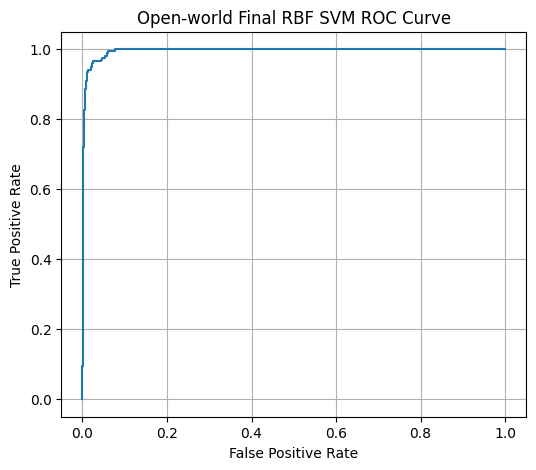

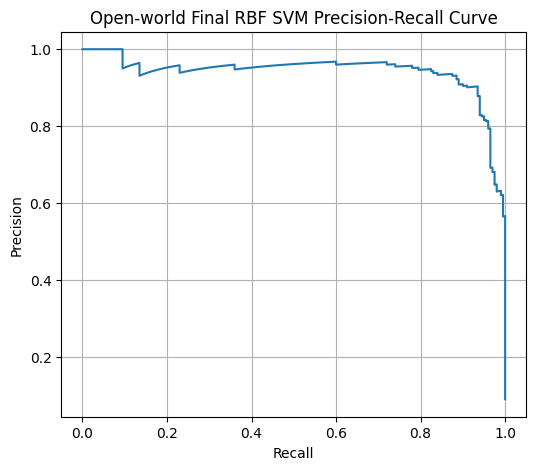

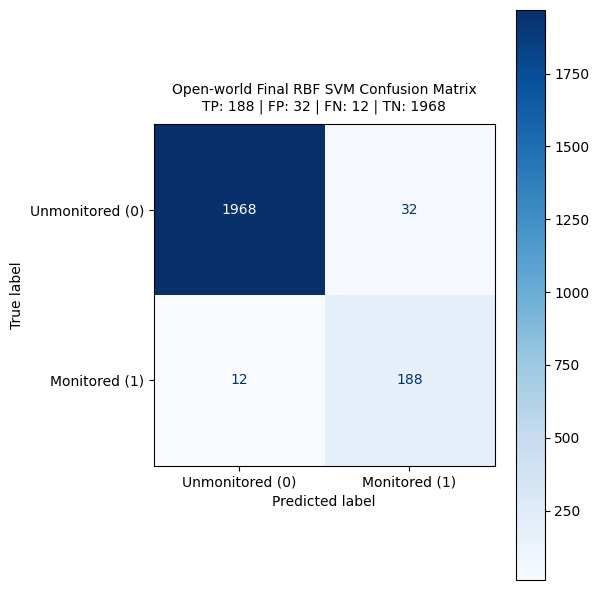

In [ ]:
# Open-world Data Generation
# Combines Monitored (1) and Unmonitored (0) feature sets and labels for the binary classification task.
X_mon_ow = mon_features.head(MON_KEEP)
y_mon_ow = np.ones(len(X_mon_ow), dtype=int)

X_unmon_ow = unmon_features.head(SAMPLE_SIZE_UNMON)
y_unmon_ow = np.zeros(len(X_unmon_ow), dtype=int)

X_open = pd.concat([X_mon_ow, X_unmon_ow], ignore_index=True).values
y_open = np.concatenate([y_mon_ow, y_unmon_ow])

# Output: Final dataset shape
print(f"Dataset ready: X_open shape={X_open.shape}, y_open shape={y_open.shape}. (Imbalance: 1:{SAMPLE_SIZE_UNMON/MON_KEEP:.0f})")

# Conducts hyperparameter tuning and evaluation for the Open-world (binary class) scenario.
def run_open_world_tuning(X_data, y_labels):
    is_open_world = True
    scoring = 'roc_auc'
    class_weight = 'balanced'

    # Splits data and scales features.
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_labels, test_size=0.2, random_state=42, stratify=y_labels
    )
    scaler = StandardScaler(); X_train_scaled = scaler.fit_transform(X_train); X_test_scaled = scaler.transform(X_test)
    best_results = {}

    print("\n===============================================")
    print(f"Phase 1: Open-world Kernel Comparison and Coarse Search (ROC_AUC)")
    print("===============================================")

    coarse_grids = {
        'linear': {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
        'poly': {'C': [0.1, 1, 10, 100], 'degree': [2, 3], 'kernel': ['poly']},
        'rbf': {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
        'sigmoid': {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['sigmoid']}
    }

    # Execute Coarse Grid Search for each kernel.
    for kernel_name, params in coarse_grids.items():
        start_time = time.time()
        print(f"-> Coarse Search: Testing {kernel_name.upper()} kernel...")

        base_params = {'probability': is_open_world, 'class_weight': class_weight, 'random_state': 42}
        base_estimator = SVC(**base_params)

        grid = GridSearchCV(base_estimator, params, cv=2, scoring=scoring, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)

        best_score = grid.best_score_; best_params = grid.best_params_
        best_results[kernel_name] = {'score': best_score, 'params': best_params}

        print(f"   Score: {best_score:.4f}, Best Params: {best_params}, Time: {time.time()-start_time:.1f}s")

    rbf_score = best_results.get('rbf', {}).get('score', 0)
    linear_score = best_results.get('linear', {}).get('score', 0)

    # Output: Final kernel selection conclusion
    if rbf_score > linear_score and rbf_score > 0.0:
        print(f"\n*** Kernel Selection Conclusion: RBF kernel ({rbf_score:.4f}) significantly outperforms Linear ({linear_score:.4f}). RBF is selected.")
    else:
        print("\n*** Kernel Selection Conclusion: RBF kernel showed the highest performance and is selected for Phase 2 Fine Tuning.")

    # 2. Fine Grid (RBF only)
    if 'rbf' in best_results:
        rbf_best_c = best_results['rbf']['params']['C']; rbf_best_gamma = best_results['rbf']['params']['gamma']

        print("\n===============================================")
        print(f"Phase 2: RBF Fine Search (Near C={rbf_best_c}, Gamma={rbf_best_gamma})")
        print("===============================================")

        C_fine_raw = [rbf_best_c * f for f in [0.5, 1, 2]]; gamma_fine_raw = [rbf_best_gamma * f for f in [0.5, 1, 2]]

        fine_grid = {
            'C': [c for c in np.unique(C_fine_raw) if c >= 0.001],
            'gamma': [g for g in np.unique(gamma_fine_raw) if g >= 0.0001],
            'kernel': ['rbf']
        }

        start_time = time.time()
        grid_fine = GridSearchCV(SVC(probability=is_open_world, class_weight=class_weight, random_state=42), fine_grid, cv=2, scoring=scoring, n_jobs=-1)
        grid_fine.fit(X_train_scaled, y_train)

        final_best_model = grid_fine.best_estimator_
        print(f"-> Fine Search Complete. Score: {grid_fine.best_score_:.4f}, Best Params: {grid_fine.best_params_}, Time: {time.time()-start_time:.1f}s")

        # 3. Final Evaluation
        y_pred = final_best_model.predict(X_test_scaled)

        print("\n===============================================")
        print("Phase 3: Final RBF Model Performance Evaluation")
        print("===============================================")

        # Output: Final evaluation metrics
        y_score = final_best_model.predict_proba(X_test_scaled)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        print(f"Score - Precision: {precision:.4f}")
        print(f"Score - Recall: {recall:.4f}")

        print(f"Score - ROC-AUC ({scoring.upper()} metric): {roc_auc_score(y_test, y_score):.4f}")
        print(f"Score - Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

        # Confusion Matrix interpretation output
        print(f"Summary - Confusion Matrix Analysis:")
        plot_curves(y_test, y_score, "Open-world Final RBF SVM")

        # Plot Confusion Matrix with integrated title
        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        title_string = (
            f"Open-world Final RBF SVM Confusion Matrix\n"
            f"TP: {TP} | FP: {FP} | FN: {FN} | TN: {TN}"
        )

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unmonitored (0)', 'Monitored (1)'])
        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(cmap=plt.cm.Blues, ax=ax)

        ax.set_title(title_string, fontsize=10, pad=10)
        plt.tight_layout()
        plt.show()

    return best_results, final_best_model

# ============================================
# Main Execution Logic (Call Section)
# ============================================

print("\n--- Open-world (11,000 Samples, 1:10 Imbalance) Kernel Comparison and Tuning ---")
ow_results, ow_best_model = run_open_world_tuning(X_open, y_open)

# 5. Feature Importance Analysis and Model Reduction

* **Objective:** To evaluate the feasibility of **model compression** by analyzing feature importance in the $\text{Open-world}$ scenario.
* **Setting:** Using **the same dataset** as the previous step, **the optimal kernel and hyperparameter values** found in the previous step were utilized.
* **Phase 1: Feature Importance Analysis**
    * Trains a $\mathbf{RandomForest}$ classifier to calculate the importance scores for the **19 features**.
    * Identifies and outputs the **Top 10 most important features**.
    * Visualizes feature importance using a **Bar Chart** to show the dominance of volume/flow features.
* **Phase 2: Top-k Performance Comparison**
    * Runs $\text{SVM}$ training using only the Top-k features, where $\mathbf{k=\{3, 5, 10, 15, 20\}}$.
    * Measures performance using $\mathbf{Accuracy, F1, ROC-AUC, Precision,\ and\ Recall}$.
* **Result Output:** Displays a **performance table** and a **line graph** plotting all metrics versus the number of features ($\text{k}$) to quantify performance retention after reduction.

Training RF classifier for feature importance calculation...
Top 10 most important features: ['n_total', 'n_in', 'cum_abs_sum', 'cum_max_abs', 'cum_final', 'n_bursts', 'initial_n_out', 'initial_n_in', 'mean_inter_time', 'std_inter_time']


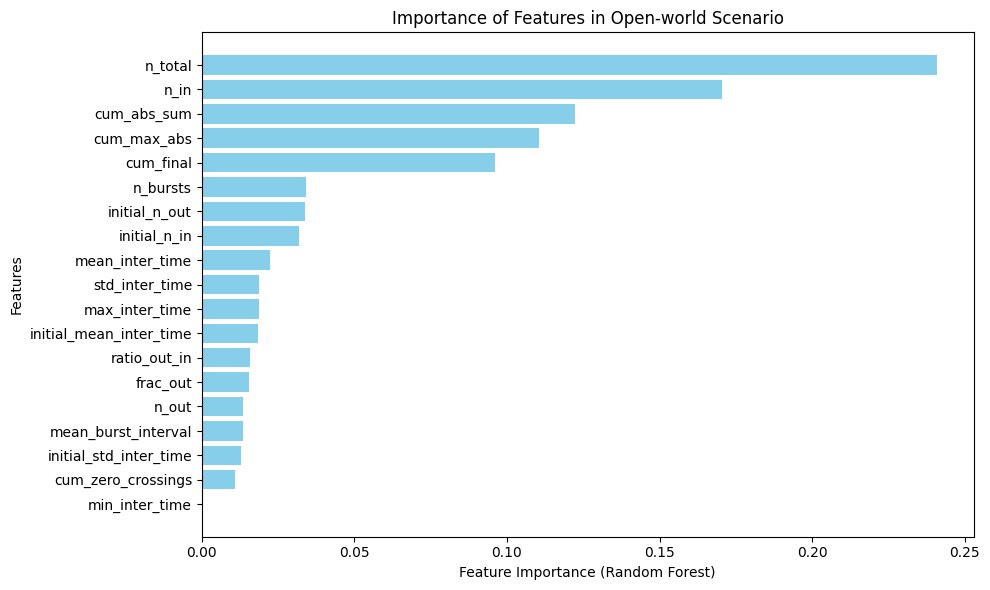


--- Running Top-k Feature Comparison ---
-> Testing k = 3 features...
-> Testing k = 5 features...
-> Testing k = 10 features...
-> Testing k = 15 features...
-> Testing k = 20 features...

Experiment Complete.


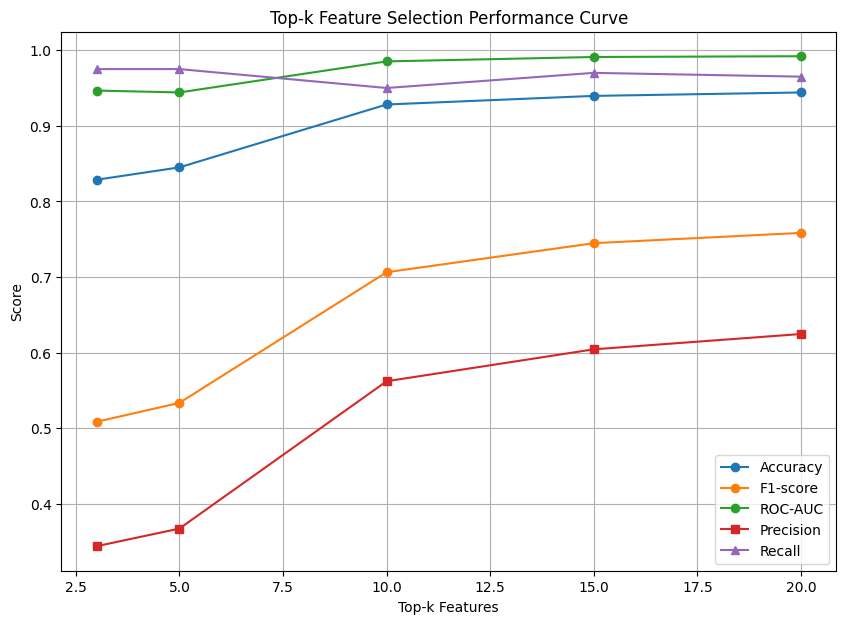


--- Performance Table ---
    k  Accuracy  Precision  Recall        F1   ROC-AUC
0   3  0.828636   0.343915   0.975  0.508475  0.946603
1   5  0.845000   0.367232   0.975  0.533516  0.944128
2  10  0.928182   0.562130   0.950  0.706320  0.985170
3  15  0.939545   0.604361   0.970  0.744722  0.991011
4  20  0.944091   0.624595   0.965  0.758350  0.992023

Total experiment time: 664.1s


In [ ]:
# ============================================
# 7) RF Importance-based Feature Selection Function
# ============================================

# Runs Top-k feature selection using Random Forest importance and evaluates SVM performance.
def run_feature_selection_experiment(X_open, y_open, feature_names):

    # 1) Calculates feature importance using RandomForest
    rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1, class_weight='balanced')
    print("Training RF classifier for feature importance calculation...")
    rf.fit(X_open, y_open)

    rf_importances = rf.feature_importances_
    ranked_indices = np.argsort(rf_importances)[::-1]
    ranked_names = feature_names[ranked_indices]

    print("Top 10 most important features:", ranked_names[:10].tolist())

    # Output: Feature Importance Bar Chart
    plt.figure(figsize=(10, 6))
    plt.barh(ranked_names[::-1], rf_importances[ranked_indices][::-1], color='skyblue')
    plt.xlabel("Feature Importance (Random Forest)")
    plt.ylabel("Features")
    plt.title("Importance of Features in Open-world Scenario")
    plt.tight_layout()
    plt.show()

    # 2) k vs Performance Comparison
    k_list = [3, 5, 10, 15, 20]; acc_list, f1_list, auc_list = [], [], []
    precision_list, recall_list = [], []

    print("\n--- Running Top-k Feature Comparison ---")

    for k in k_list:
        print(f"-> Testing k = {k} features...")
        top_k_idx = ranked_indices[:k]
        X_open_topk = X_open[:, top_k_idx]

        X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_open_topk, y_open, test_size=0.2, stratify=y_open, random_state=42)

        scaler_k = StandardScaler(); X_train_k = scaler_k.fit_transform(X_train_k); X_test_k = scaler_k.transform(X_test_k)

        clf_k = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
        clf_k.fit(X_train_k, y_train_k)

        y_pred_k = clf_k.predict(X_test_k); y_score_k = clf_k.predict_proba(X_test_k)[:, 1]

        acc_list.append(accuracy_score(y_test_k, y_pred_k)); f1_list.append(f1_score(y_test_k, y_pred_k)); auc_list.append(roc_auc_score(y_test_k, y_score_k))
        precision_list.append(precision_score(y_test_k, y_pred_k))
        recall_list.append(recall_score(y_test_k, y_pred_k))

    print("\nExperiment Complete.")

    # 3) Output Performance Table and Curve
    plt.figure(figsize=(10, 7))
    plt.plot(k_list, acc_list, marker='o', label='Accuracy')
    plt.plot(k_list, f1_list, marker='o', label='F1-score')
    plt.plot(k_list, auc_list, marker='o', label='ROC-AUC')
    plt.plot(k_list, precision_list, marker='s', label='Precision')
    plt.plot(k_list, recall_list, marker='^', label='Recall')

    plt.title("Top-k Feature Selection Performance Curve"); plt.xlabel("Top-k Features"); plt.ylabel("Score"); plt.grid(True); plt.legend(); plt.show()

    perf_table = pd.DataFrame({"k": k_list, "Accuracy": acc_list, "Precision": precision_list, "Recall": recall_list, "F1": f1_list, "ROC-AUC": auc_list})
    print("\n--- Performance Table ---")
    print(perf_table)

    return

# --- Main Execution ---
feature_names = mon_features.columns.values
run_feature_selection_experiment(X_open, y_open, feature_names)


print(f"\nTotal experiment time: {time.time() - start_total:.1f}s")